In [1]:
import pandas as pd
import os
import numpy as np
import json
from scipy.stats import iqr
import matplotlib.pyplot as plt

In [2]:
# Definiere die relevanten Stats (Spaltennamen in deiner CSV):
relevant_stats = [
        "STAT_ACTION_EAT",
        "STAT_ACTION_DRINK",
        "STAT_ACTION_EQUIP_GEAR",
        "STAT_ACTION_COOK_STEAK",
        "STAT_ACTION_IGNITE_FIRE_MATCHBOX",
        "STAT_ACTION_IGNITE_FIRE_HAND_DRILL",
        "STAT_ACTION_SHAVE",
        "STAT_ACTION_GUT_DEER",
        "STAT_ACTION_APPLY_MEDS_ON_SURVIVOR",
        "STAT_INFECTED_KILL_COUNT",
        "STAT_SURVIVOR_KILL_MAX_DIST",
        "STAT_INFECTED_SOLDIER_KILL_COUNT",
        "STAT_SURVIVOR_MELEE_KILL_COUNT",
        "STAT_SURVIVOR_HEADSHOT_COUNT",
        "STAT_INFECTED_HEADSHOT_COUNT",
        "STAT_HEADSHOT_COUNT"
]

# Pfad zu deiner CSV-Datei
csv_file = "221100_stats_DayZ.csv"
app_id = 221100
name = "DayZ"

# DataFrame einlesen
df = pd.read_csv(csv_file)

In [15]:
# -------------------------------
# 4) FUNKTIONEN FÜR IQR-BEREINIGUNG UND PERZENTILE
# -------------------------------
def remove_outliers_iqr(series):
    """
    Entfernt Ausreißer mithilfe des Interquartilsabstands (IQR).
    Gibt die bereinigte Series und die Anzahl der entfernten Werte zurück.
    """
    data = series.dropna().to_numpy()
    if len(data) < 4:
        return series, 0  # Keine Werte oder zu wenige für IQR-Berechnung

    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr_value = iqr(data)  # aus scipy.stats
    print(q1)
    print(q3)
    print(iqr_value)
    lower_bound = q1 - 4 * iqr_value
    upper_bound = q3 + 4 * iqr_value
    
    # Maske der Werte, die im akzeptablen Bereich liegen
    mask = (series >= lower_bound) & (series <= upper_bound)
    removed_count = (~mask).sum()
    cleaned_series = series[mask]
    
    return cleaned_series, removed_count

In [18]:
#Perzentile berechnen und Ausreißer entfernen
def calculate_percentiles(values, ptiles = [i for i in range(100)]):
    """
    Berechnet die angegebenen Perzentile für eine gegebene Werte-Serie.
    """
    result = {}
    data = values.dropna().to_numpy()
    for p in ptiles:
        result[f"{p}%"] = np.percentile(data, p)
    return result

# -------------------------------
# 5) AUSWERTUNG PRO SPALTE
# -------------------------------
results = {}         # Perzentil-Ergebnisse pro Statistik
exclusion_stats = {} # Daten zum Ausschluss (Anzahl/Werte)

for stat in relevant_stats:
    if stat not in df.columns:
        continue  # Falls Spalte fehlt
    
    series = df[stat].dropna()
    if series.empty:
        continue
    
    # Ausreißer entfernen
    cleaned_series, removed_count = remove_outliers_iqr(series)
    original_count = len(series)
    cleaned_count = len(cleaned_series)
    
    if cleaned_count == 0:
        continue  # Alles wurde entfernt
    
    # Perzentile berechnen
    stat_percentiles = calculate_percentiles(cleaned_series)#evtl anpassen, falls Bereinigung nötig
    
    # Ergebnisse ablegen
    results[stat] = stat_percentiles
    exclusion_stats[stat] = {
        "original_count": original_count,
        "cleaned_count": cleaned_count,
        "removed_count": removed_count,
        "percent_excluded": (removed_count / original_count) * 100
    }

5.0
55.0
50.0
3.0
26.0
23.0
58.5
879.5
821.0
3.0
14.5
11.5
1.0
2.0
1.0
1.0
3.0
2.0
1.0
1.0
0.0
1.0
3.5
2.5
1.0
21.5
20.5
11.0
120.0
109.0
6.07688581943512
118.09924125671385
112.02235543727873
4.0
56.25
52.25
1.0
4.0
3.0
1.0
2.0
1.0
3.0
47.0
44.0
3.0
39.25
36.25


Die zusammengefassten Perzentile wurden in 221100_statistische_auswertung.csv gespeichert.
3.0
39.25
36.25


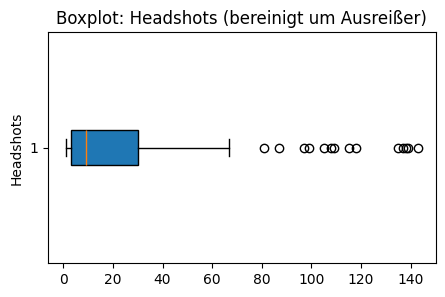

In [19]:
# -------------------------------
# 6) ERGEBNISSE IN CSV SCHREIBEN
# -------------------------------
rows_for_csv = []

for stat, stat_percentiles in results.items():
    row = {
        "stat": stat,
        "original_count": exclusion_stats[stat]["original_count"],
        "cleaned_count": exclusion_stats[stat]["cleaned_count"],
        "removed_count": exclusion_stats[stat]["removed_count"],
        "percent_excluded": exclusion_stats[stat]["percent_excluded"]
    }
    # Perzentile anhängen
    for p_label, p_value in stat_percentiles.items():
        row[p_label] = p_value
    
    rows_for_csv.append(row)

# DataFrame aus den Auswertungsergebnissen
results_df = pd.DataFrame(rows_for_csv)
results_df.to_csv(rf"C:/Users/paulu/OneDrive/Desktop/WebMining_final/Dashboard/{app_id}_statistische_auswertung.csv", index=False)
print(f"Die zusammengefassten Perzentile wurden in {app_id}_statistische_auswertung.csv gespeichert.")

# -------------------------------
# 7) BEISPIEL: BOX PLOT FÜR "STAT_HEADSHOT_COUNT"
# -------------------------------
if "STAT_HEADSHOT_COUNT" in df.columns:
    # Daten erneut aus "df" nehmen
    # und die IQR-Bereinigung anwenden (damit der Boxplot ohne Ausreißer gemalt wird)
    kd_series = df["STAT_HEADSHOT_COUNT"].dropna()
    cleaned_series_kd, _ = remove_outliers_iqr(kd_series)
    
    # Matplotlib-Boxplot zeichnen
    plt.figure(figsize=(5, 3))
    plt.boxplot(cleaned_series_kd, vert=False, patch_artist=True)
    plt.title("Boxplot: Headshots (bereinigt um Ausreißer)")
    plt.ylabel("Headshots")
    plt.show()


In [7]:
#display all max and min values as well as the difference between them
for stat in relevant_stats:
    print(f"Statistik: {stat}")
    print(f"  Max: {df[stat].max()}")
    print(f"  Min: {df[stat].min()}")
    print(f"  Difference: {df[stat].max() - df[stat].min()}")
    print()

Statistik: total_kills
  Max: 1000001355.0
  Min: 0.0
  Difference: 1000001355.0

Statistik: total_deaths
  Max: 100017938.0
  Min: 0.0
  Difference: 100017938.0

Statistik: total_time_played
  Max: 2036165379.0
  Min: 0.0
  Difference: 2036165379.0

Statistik: total_wins
  Max: 1000000866.0
  Min: 0.0
  Difference: 1000000866.0

Statistik: total_kills_headshot
  Max: 1000000711.0
  Min: 0.0
  Difference: 1000000711.0

Statistik: total_shots_hit
  Max: 1000003469.0
  Min: 0.0
  Difference: 1000003469.0

Statistik: total_shots_fired
  Max: 1000008962.0
  Min: 0.0
  Difference: 1000008962.0

Statistik: total_rounds_played
  Max: 1000001876.0
  Min: 0.0
  Difference: 1000001876.0

Statistik: total_matches_won
  Max: 100000465.0
  Min: 0.0
  Difference: 100000465.0

Statistik: total_matches_played
  Max: 100000934.0
  Min: 0.0
  Difference: 100000934.0

Statistik: total_gg_matches_won
  Max: 15015.0
  Min: 0.0
  Difference: 15015.0

Statistik: total_gg_matches_played
  Max: 15323.0
  Min: 